In [153]:
import sympy
from sympy import pi
from copy import copy, deepcopy
# import numpy as np

# plotting
import networkx as nx;
import matplotlib.pyplot as plt

# Symbolic ZX
A simple ZX representation with symbolic support

Z - green, X - red

In [154]:
class Node:
    def __init__(self, angle=0, label=""):
        self.angle = angle % (2*pi)
        self.label = label
    @property
    def isX(self): return self.color == "red"
    @property
    def isZ(self): return self.color == "green"
    
    ''' check if angle is Zero '''
    def isZero(self): return self.angle == 0

class RedNode(Node):
    @property
    def color(self): return "red"

class GreenNode(Node):
    @property
    def color(self): return "green"
    
class HadamardNode(Node):
    @property
    def color(self): return "yellow"
    
class InputNode(Node):
    @property
    def color(self): return "black"

class OutputNode(Node):
    @property
    def color(self): return "white"

Z = GreenNode
X = RedNode

def getNode(color):
    if color == "red": return X
    if color == "green": return Z
    if color == "black": return InputNode
    if color == "white": return OutputNode
    if color == "yellow": return HadamardNode
    raise Exception("invalid color")
    
class Graph:
    def __init__(self):
        # :: Int -- index of next unused node
        self.node_counter = 0 
        # :: Map idx Node -- nodes
        self.nodes = dict() 
        # :: Map idx (Set idx) -- edges
        self.edges = dict() 
    
    ''' :: Graph -> Node -> Int '''
    def add_node(self, node: Node):
        idx = self.node_counter
        self.nodes[idx] = node
        self.node_counter += 1
        return idx
    
    ''' :: Graph -> Int -> Int -> Unit '''
    def add_edge(self, i: int, j: int):
        if i not in self.edges:
            self.edges[i] = set()
        if j not in self.edges:
            self.edges[j] = set()
        
        self.edges[i].add(j)
        self.edges[j].add(i)
        
    ''' :: Graph -> Int -> Unit '''
    def remove_node(self, idx: int):
        if idx in self.nodes:
            del self.nodes[idx]
            del self.edges[idx]
            for j in self.edges:
                if idx in self.edges[j]:
                    self.edges[j].remove(idx)
                    
    ''' :: Graph -> Int -> Int -> Unit '''
    def remove_edge(self, i: int, j: int):
        if i in self.edges and j in self.edges[i]:
            self.edges[i].remove(j)
        if j in self.edges and i in self.edges[j]:
            self.edges[j].remove(i)

    ''' :: Graph -> Unit '''
    def show(self):
        G = nx.Graph()
        
        nodes = {"red": [], "green": [], "black": [], "white": []}
        angles = dict()
        edge_list = []
        for i in self.nodes:
            nodes[self.nodes[i].color].append(i)
            G.add_node(i)
            if not self.nodes[i].isZero():
                angles[i] = self.nodes[i].angle
            for j in self.edges[i]:
                if i < j: edge_list.append((i, j))
        G.add_edges_from(edge_list)
            
        # plot!
        pos = nx.spring_layout(G)
        nx.draw_networkx_nodes(G, pos, 
                               nodelist=nodes["red"], node_color="#ef5350")
        nx.draw_networkx_nodes(G, pos, 
                               nodelist=nodes["green"], node_color="#B2EBF2")
        nx.draw_networkx_nodes(G, pos, 
                               nodelist=nodes["black"], node_color="#212121")
        nx.draw_networkx_nodes(G, pos, 
                               nodelist=nodes["white"], node_color="#EEEEEE")
        nx.draw_networkx_edges(G, pos, edge_list)
        
        nx.draw_networkx_labels(G, pos, angles, font_size=10)
        plt.show()
        
    def to_circuit(self):
        ''' Convert to circuit '''
        pass

In [155]:
class Gate:
    def __init__(self):
        pass

class Circuit:
    def __init__(self):
        pass
    
    def to_graph(self):
        pass

In [156]:
''' Looks for the first occurence of a pattern
and rewrites it
'''
class Pattern:
    def __init__(self, graph):
        self.graph = graph
        self.matched = None

    def match(self):
        raise Exception("undefined")
    
    # Constraints:
    # 1. Do not back out of a rewrite
    # 2. Call only after `match` succeeds
    def rewrite(self):
        raise Exception("undefined")
    
    # For safe use, only call this
    def match_and_rewrite(self):
        if self.match():
            self.rewrite()
            self.matched = None
            return True
        self.matched = None
        return False
        
def rewrite_all(g, p):
    while p(g).match_and_rewrite():
        pass

In [157]:
class SpiderFusion(Pattern):
    @property
    def base_color(self): return "green"
    
    def match(self):
        g = self.graph
        for i in g.nodes:
            if g.nodes[i].color != self.base_color:
                continue
            for j in g.edges[i]:
                if g.nodes[i].color == g.nodes[j].color:
                    self.matched = [i, j]
                    return True        
        return False

    def rewrite(self):
        i, j = self.matched
        
        g = self.graph
        k = g.add_node(getNode(g.nodes[i].color)(g.nodes[i].angle + g.nodes[j].angle))
        
        neigh = set()
        for l in g.edges[i]: neigh.add(l)
        for l in g.edges[j]: neigh.add(l)
        neigh.remove(i)
        neigh.remove(j)
        
        for l in neigh: g.add_edge(k, l)
            
        g.remove_node(i)
        g.remove_node(j)


class ZSpiderFusion(SpiderFusion):
    @property
    def base_color(self): return "green"

class XSpiderFusion(SpiderFusion):
    @property
    def base_color(self): return "red"

class IdentityRule(Pattern):
    def match(self):
        g = self.graph
        for i in g.nodes:
            if len(g.edges[i]) == 2 and g.nodes[i].isZero():
                self.matched = i
                return True
        return False
            
    def rewrite(self):
        i = self.matched
        
        g = self.graph
        [j, k] = list(g.edges[i])
        g.add_edge(j, k)
        g.remove_node(i)

        return True

class CopyRule(Pattern):
    def match(self):
        g = self.graph
        for i in g.nodes:
            if g.nodes[i].isX and g.nodes[i].isZero():
                for j in g.edges[i]:
                    if g.nodes[j].isZ and g.nodes[j].isZero() and len(g.edges[j]) == 3:
                        self.matched = [i, j]
                        return True
        return False
    def rewrite(self):
        i, j = self.matched
        g = self.graph
        adj = deepcopy(g.edges[j])
        adj.remove(i)
        ja, jb = list(adj)
        
        u = g.add_node(X())
        v = g.add_node(X())
        g.add_edge(u, ja)
        g.add_edge(v, jb)
        g.remove_node(i)
        g.remove_node(j)

class ColorChangeRule(Pattern):
    def match(self):
        return False
    def rewrite(self):
        pass

class BialgebraRule(Pattern):
    def match(self):
        g = self.graph
        for i in g.nodes:
            if g.nodes[i].isX and g.nodes[i].isZero():
                for j in g.edges[i]:
                    if g.nodes[j].isZ and g.nodes[j].isZero() and len(g.edges[j]) == 3:
                        self.matched = [i, j]
                        return True
        return False
    def rewrite(self):
        pass

class PiCopyRule(Pattern):
    def match(self):
        return False
    def rewrite(self):
        pass

class EulerDecomposition(Pattern):
    def match(self):
        return False
    def rewrite(self):
        pass

rewriteRuleList = [
    ZSpiderFusion, 
    XSpiderFusion, 
    IdentityRule, 
    ColorChangeRule, 
    CopyRule, 
    BialgebraRule, 
    PiCopyRule,
    EulerDecomposition
]

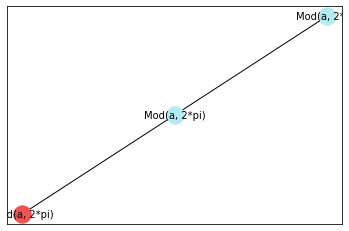

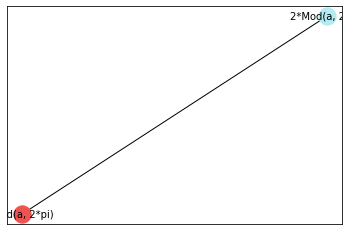

In [158]:
g = Graph()
a = sympy.Symbol('a')
v0 = g.add_node(Z(angle=a))
v1 = g.add_node(Z(angle=a))
v2 = g.add_node(X(angle=a))
g.add_edge(v0, v1)
g.add_edge(v1, v2)

g.show()
ok = ZSpiderFusion(g).match_and_rewrite()
g.show()

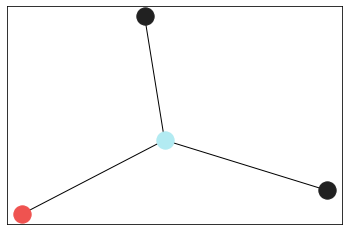

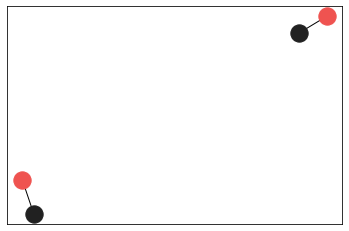

In [159]:
g = Graph()
v0 = g.add_node(X())
v1 = g.add_node(Z())
v2 = g.add_node(InputNode())
v3 = g.add_node(InputNode())
g.add_edge(v0, v1)
g.add_edge(v1, v2)
g.add_edge(v1, v3)

g.show()
ok = CopyRule(g).match_and_rewrite()
g.show()